# Project 7 - Admission rate

**Author: Linh Nguyen**<br>

**StudentID: 23161711**<br>

**Date: Sep 2022**

## 1. Load data and import package

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Capstone_project

Mounted at /content/drive
/content/drive/MyDrive/Capstone_project


In [2]:
! pip install matplotlib -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 36.6 MB/s 


In [5]:
import numpy as np
import pandas as pd
from datetime import datetime
import re
from tensorflow import keras
from keras.layers import TextVectorization
from keras.layers import Embedding
from keras import layers
import seaborn as sns
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping
import  tensorflow as tf
from gensim.models import KeyedVectors
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,ConfusionMatrixDisplay,classification_report, roc_auc_score
from scipy import stats
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier

In [6]:
import matplotlib as mpl
print(mpl.__version__)

3.5.3


In [7]:
keras.__version__

'2.9.0'

In [8]:
! ls /content/drive/MyDrive/Capstone_project/raw

diagnosis.csv  icd9toicd10cmgem.csv  pyxis.csv	 vitalsign.csv
edstays.csv    medrecon.csv	     triage.csv


# 2. Data cleansing and exploration

## 2.1 Edstay and triage table

In [9]:
edstays = pd.read_csv('raw/edstays.csv')
triage = pd.read_csv('raw/triage.csv')

In [10]:
edstay_ad = pd.merge(edstays,triage,how = 'left',on=['subject_id', 'stay_id'])

In [11]:
edstay_ad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447712 entries, 0 to 447711
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   subject_id         447712 non-null  int64  
 1   hadm_id            213911 non-null  float64
 2   stay_id            447712 non-null  int64  
 3   intime             447712 non-null  object 
 4   outtime            447712 non-null  object 
 5   gender             447712 non-null  object 
 6   race               447712 non-null  object 
 7   arrival_transport  447712 non-null  object 
 8   disposition        447712 non-null  object 
 9   temperature        423117 non-null  float64
 10  heartrate          429754 non-null  float64
 11  resprate           426337 non-null  float64
 12  o2sat              426063 non-null  float64
 13  sbp                428487 non-null  float64
 14  dbp                427644 non-null  float64
 15  pain               434095 non-null  object 
 16  ac

array([<AxesSubplot:ylabel='disposition'>], dtype=object)

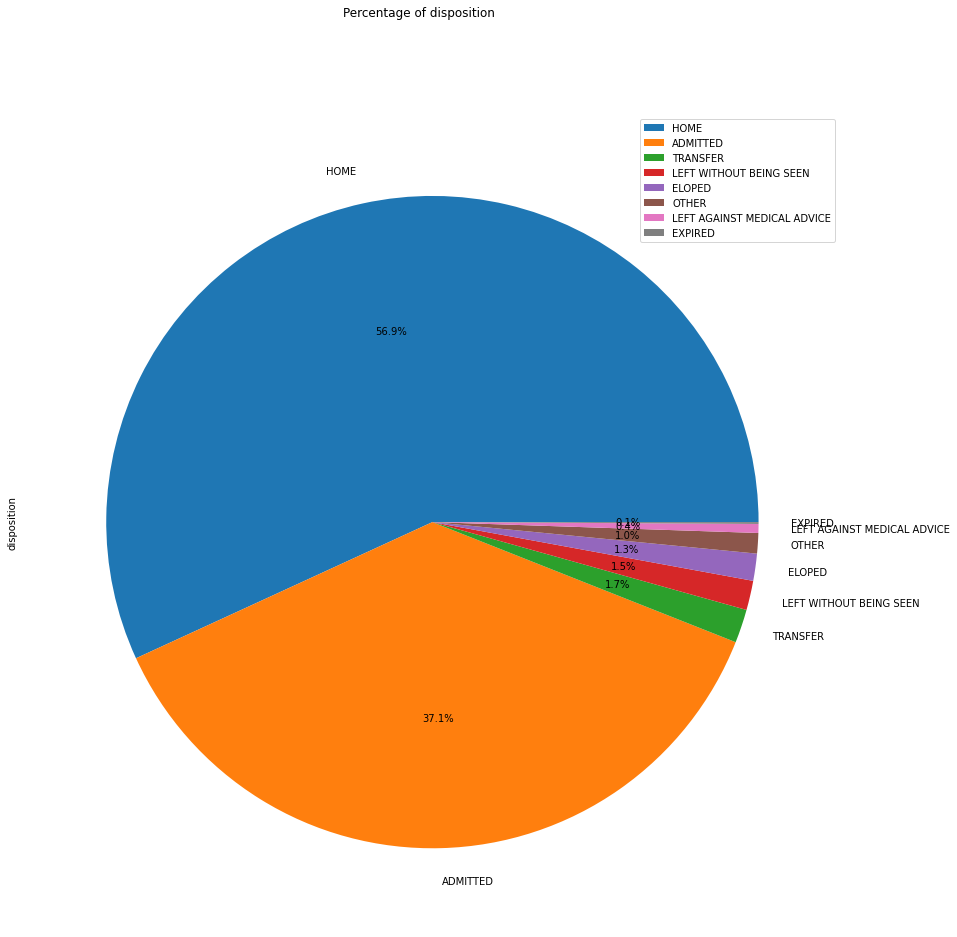

In [12]:
cls_table = pd.DataFrame(edstays['disposition'].value_counts(normalize=True))
cls_table.plot(kind='pie', y = 'disposition',subplots=True, autopct='%1.1f%%', title = "Percentage of disposition", figsize=(15,15))

In [13]:
edstay_ad['y_var_adm_text'] = edstays['disposition']
edstay_ad['intime_h'] = pd.to_datetime(edstay_ad.intime).dt.hour
edstay_ad.loc[edstay_ad['y_var_adm_text'] == 'TRANSFER', 'y_var_adm_text'] = 'ADMITTED'
edstay_ad.loc[edstay_ad['y_var_adm_text'] == 'ELOPED','y_var_adm_text'] = 'MISSING'
edstay_ad.loc[edstay_ad['y_var_adm_text'] == 'LEFT WITHOUT BEING SEEN','y_var_adm_text'] = 'MISSING'
edstay_ad.loc[edstay_ad['y_var_adm_text'] == 'OTHER','y_var_adm_text'] = 'MISSING'
edstay_ad.loc[edstay_ad['y_var_adm_text'] == 'LEFT AGAINST MEDICAL ADVICE','y_var_adm_text'] = 'MISSING'
edstay_ad.loc[edstay_ad['y_var_adm_text'] == 'EXPIRED','y_var_adm_text'] = 'MISSING'
edstay_ad = edstay_ad[edstay_ad['y_var_adm_text'] !='MISSING'].reset_index(drop = True)
edstay_ad['key'] = edstay_ad['subject_id'].astype(str)+'_'+edstay_ad['stay_id'].astype(str)

array([<AxesSubplot:ylabel='y_var_adm_text'>], dtype=object)

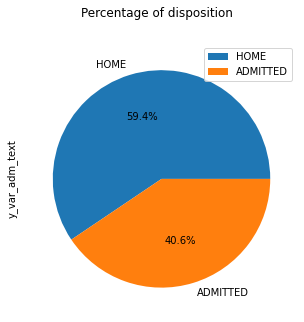

In [14]:
cls_table = pd.DataFrame(edstay_ad['y_var_adm_text'].value_counts(normalize=True))
cls_table.plot(kind='pie', y = 'y_var_adm_text',subplots=True, autopct='%1.1f%%', title = "Percentage of disposition", figsize=(5,5))

In [15]:
edstay_ad.loc[edstay_ad['race'].str.contains('WHITE'), 'race_color'] = 'WHITE'
edstay_ad.loc[edstay_ad['race'].str.contains('BLACK'), 'race_color'] = 'BLACK'
edstay_ad.loc[edstay_ad['race'].str.contains('ASIAN'), 'race_color'] = 'ASIAN'
edstay_ad.loc[edstay_ad['race'].str.contains('LATINO'), 'race_color'] = 'HISPANIC/LATINO'
edstay_ad.loc[edstay_ad['race'].str.contains('HISPANIC'), 'race_color'] = 'HISPANIC/LATINO'
edstay_ad.loc[edstay_ad['race_color'].isna(), 'race_color'] = 'OTHER'

[Text(0, 0, '0.67'),
 Text(0, 0, '0.69'),
 Text(0, 0, '0.73'),
 Text(0, 0, '0.58'),
 Text(0, 0, '0.54')]

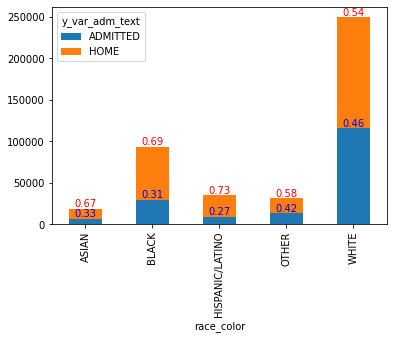

In [16]:
ax = edstay_ad.groupby(['race_color', 'y_var_adm_text']).size().unstack().plot(kind='bar', stacked=True)
percent = []
for i in range(len(ax.containers[0])):
    percent.extend([round( ax.containers[0].datavalues[i]/(ax.containers[0].datavalues[i]+ax.containers[1].datavalues[i]),2)])

ax.bar_label(ax.containers[0], labels=percent,color = "blue")
ax.bar_label(ax.containers[1], labels=[round((1 - i),2) for i in percent ],color = "red")

[Text(20, 0, '0.43'),
 Text(20, 0, '0.06'),
 Text(20, 0, '0.64'),
 Text(20, 0, '0.15'),
 Text(20, 0, '0.71')]

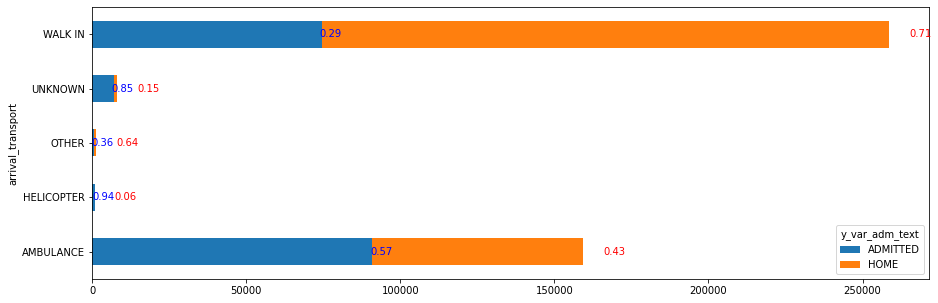

In [17]:
ax = edstay_ad.groupby(['arrival_transport', 'y_var_adm_text']).size().unstack().plot(kind='barh', stacked=True, rot = False, figsize = (15,5))
percent = []
for i in range(len(ax.containers[0])):
    percent.extend([round( ax.containers[0].datavalues[i]/(ax.containers[0].datavalues[i]+ax.containers[1].datavalues[i]),2)])

ax.bar_label(ax.containers[0], labels=percent,padding=-2,rotation=0, color = "blue")
ax.bar_label(ax.containers[1], labels=[round((1 - i),2) for i in percent ],padding=20, rotation=0, color = "red")

In [18]:
edstay_ad['DateTime_in'] = pd.to_datetime(edstay_ad['intime'], format='%d/%m/%Y %H:%M')
edstay_ad['DateTime_out'] = pd.to_datetime(edstay_ad['outtime'], format='%d/%m/%Y %H:%M')

In [19]:
edstay_ad['stay'] = edstay_ad['DateTime_out'] - edstay_ad['DateTime_in']

In [20]:
edstays_admit_1 = edstay_ad.sort_values(by = ['subject_id','DateTime_in'], ascending=True).reset_index(drop=True)

In [21]:
edstay_hist = {}
for i in range(len(edstays_admit_1)):
    if i == 0:
        edstay_hist[i] = 'NO HISTORY'
    else:
        if edstays_admit_1['subject_id'][i] == edstays_admit_1['subject_id'][i-1]:
            edstay_hist[i] = edstays_admit_1['y_var_adm_text'][i-1]
        else:
            edstay_hist[i] = 'NO HISTORY'

In [22]:
edstay_laststay = {}
for i in range(len(edstays_admit_1)):
    if i == 0:
        edstay_laststay[i] = np.timedelta64(0, 'D')
    else:
        if edstays_admit_1['subject_id'][i] == edstays_admit_1['subject_id'][i-1]: 
          edstay_laststay[i] = edstays_admit_1['stay'][i-1]+edstay_laststay[i-1]
        else:
            edstay_laststay[i] = np.timedelta64(0, 'D')

In [23]:
df1 = pd.DataFrame.from_dict(edstay_hist,orient='index')
df1.columns = ['historical_stay_status']
edstays_admit_1 = pd.merge(edstays_admit_1,df1,how = 'left',left_index=True,right_index=True) 

In [24]:
df1 = pd.DataFrame.from_dict(edstay_laststay,orient='index')
df1.columns = ['historical_stay_length']
edstays_admit_1 = pd.merge(edstays_admit_1,df1,how = 'left',left_index=True,right_index=True) 

In [25]:
edstays_admit_1['historical_stay_length_in_day'] = edstays_admit_1['historical_stay_length']/(np.timedelta64(1, 'D'))

In [26]:
edstays_admit_2 = pd.merge(edstay_ad,edstays_admit_1[['historical_stay_status','historical_stay_length','historical_stay_length_in_day','subject_id','stay_id']],how = 'left',on=['subject_id', 'stay_id'])

[Text(0, 0, '0.35'), Text(0, 0, '0.73'), Text(0, 0, '0.62')]

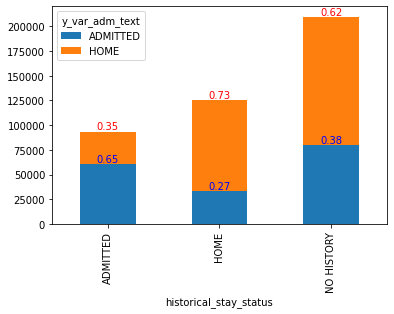

In [27]:
ax = edstays_admit_2.groupby(['historical_stay_status', 'y_var_adm_text']).size().unstack().plot(kind='bar', stacked=True)
percent = []
for i in range(len(ax.containers[0])):
    percent.extend([round( ax.containers[0].datavalues[i]/(ax.containers[0].datavalues[i]+ax.containers[1].datavalues[i]),2)])

ax.bar_label(ax.containers[0], labels=percent,color = "blue")
ax.bar_label(ax.containers[1], labels=[round((1 - i),2) for i in percent ],color = "red")

<AxesSubplot:xlabel='y_var_adm_text', ylabel='historical_stay_length_in_day'>

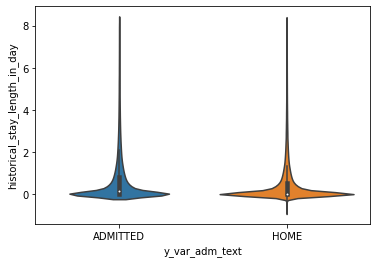

In [28]:
df = edstays_admit_2['historical_stay_length_in_day']
df = df[(np.abs(stats.zscore(df)) < 2)]
df = pd.merge(df,edstays_admit_2['y_var_adm_text'],how = 'left',left_index=True,right_index=True)
sns.violinplot(x = 'y_var_adm_text', y = 'historical_stay_length_in_day', data = df)

<AxesSubplot:xlabel='y_var_adm_text', ylabel='intime_h'>

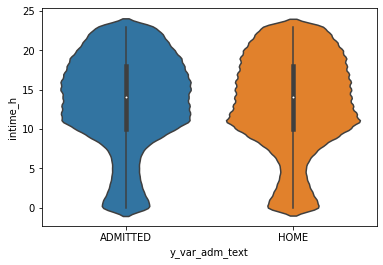

In [29]:
df = edstays_admit_2['intime_h']
df = pd.merge(df,edstays_admit_2['y_var_adm_text'],how = 'left',left_index=True,right_index=True)
sns.violinplot(x = 'y_var_adm_text', y = 'intime_h', data = df)

[Text(0, 0, '0.61'),
 Text(0, 0, '0.61'),
 Text(0, 0, '0.61'),
 Text(0, 0, '0.6'),
 Text(0, 0, '0.58'),
 Text(0, 0, '0.58'),
 Text(0, 0, '0.62'),
 Text(0, 0, '0.67'),
 Text(0, 0, '0.67'),
 Text(0, 0, '0.64'),
 Text(0, 0, '0.62'),
 Text(0, 0, '0.6'),
 Text(0, 0, '0.59'),
 Text(0, 0, '0.58'),
 Text(0, 0, '0.58'),
 Text(0, 0, '0.56'),
 Text(0, 0, '0.56'),
 Text(0, 0, '0.57'),
 Text(0, 0, '0.57'),
 Text(0, 0, '0.58'),
 Text(0, 0, '0.6'),
 Text(0, 0, '0.6'),
 Text(0, 0, '0.6'),
 Text(0, 0, '0.61')]

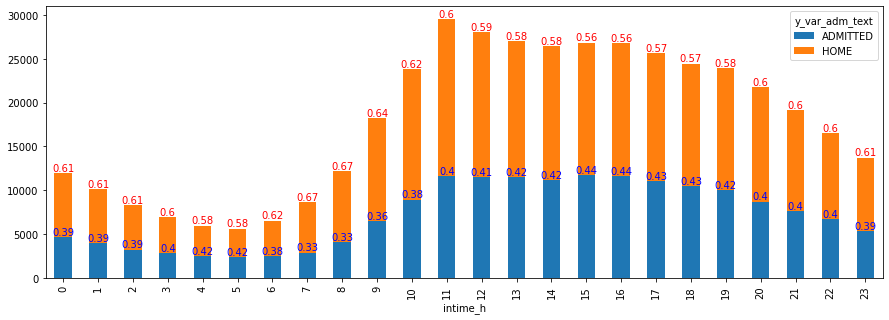

In [30]:
ax = df.groupby(['intime_h', 'y_var_adm_text']).size().unstack().plot(kind='bar', stacked=True, figsize = (15,5))
percent = []
for i in range(len(ax.containers[0])):
    percent.extend([round( ax.containers[0].datavalues[i]/(ax.containers[0].datavalues[i]+ax.containers[1].datavalues[i]),2)])

ax.bar_label(ax.containers[0], labels=percent,color = "blue")
ax.bar_label(ax.containers[1], labels=[round((1 - i),2) for i in percent ],color = "red")


array([[<AxesSubplot:title={'center':'temperature'}>,
        <AxesSubplot:title={'center':'heartrate'}>,
        <AxesSubplot:title={'center':'resprate'}>],
       [<AxesSubplot:title={'center':'o2sat'}>,
        <AxesSubplot:title={'center':'sbp'}>,
        <AxesSubplot:title={'center':'dbp'}>],
       [<AxesSubplot:title={'center':'acuity'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

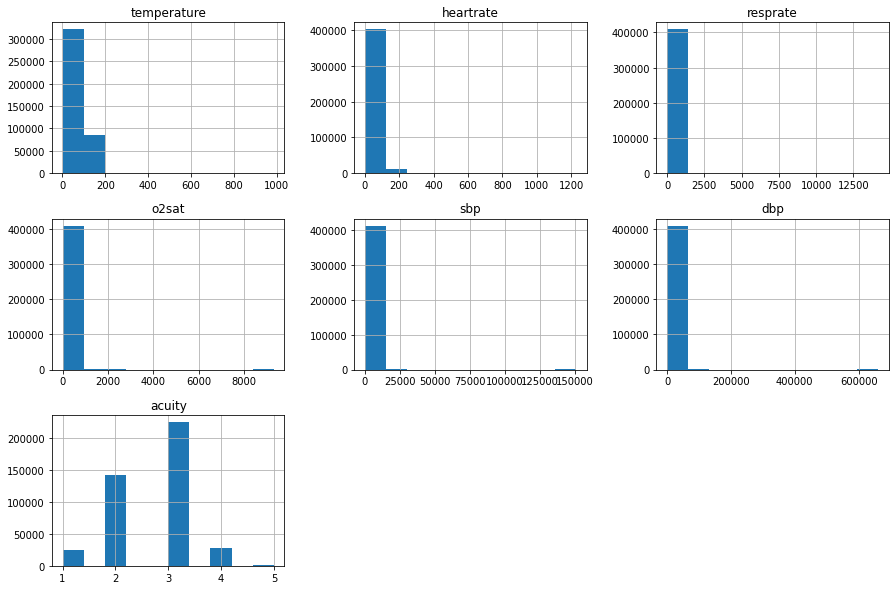

In [31]:
edstays_admit_2[['temperature','heartrate','resprate','o2sat','sbp','dbp','acuity']].hist(figsize=[15,10])

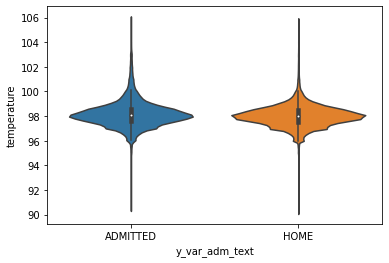

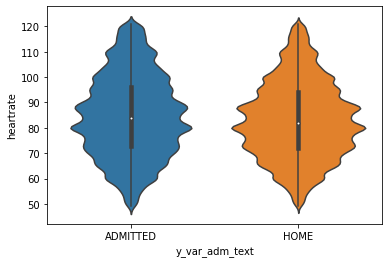

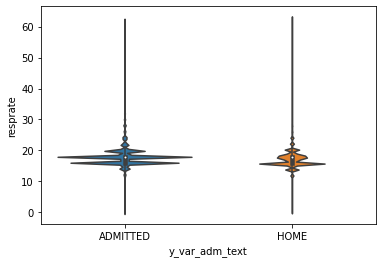

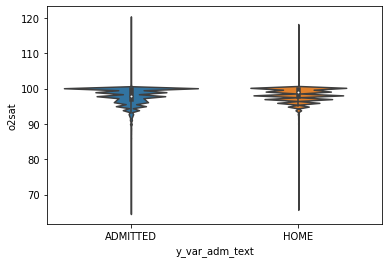

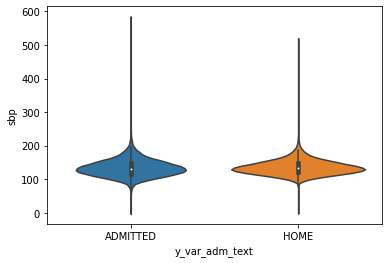

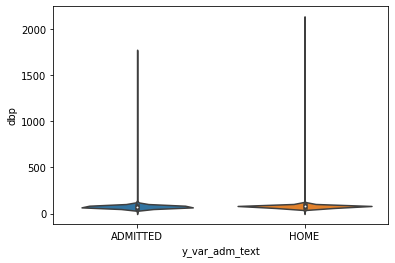

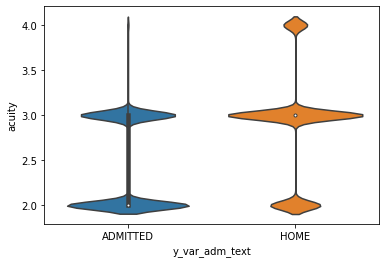

In [32]:
lst_col = ['temperature','heartrate','resprate','o2sat','sbp','dbp','acuity']
for i in lst_col:
    plt.figure()
    df = edstays_admit_2[[i]].dropna()
    df = df[(np.abs(stats.zscore(df)) < 2)]
    df = pd.merge(df,edstays_admit_2['y_var_adm_text'],how = 'left',left_index=True,right_index=True)
    sns.violinplot(x = 'y_var_adm_text', y = i, data = df)

<AxesSubplot:xlabel='disposition', ylabel='acuity'>

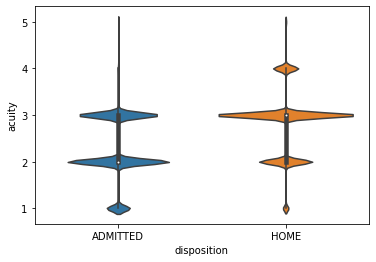

In [33]:
df = pd.read_csv('raw/edstays.csv')
df = pd.merge(df,triage,how = 'left',on=['subject_id', 'stay_id'])
df = df[df['disposition'].isin(['HOME', 'ADMITTED'])]
df = df[['acuity', 'disposition']].dropna()

sns.violinplot(x = 'disposition', y = 'acuity', data = df)

In [34]:
df[df['disposition'].isin(['HOME', 'ADMITTED'])]

,acuity,disposition
0,3.0,ADMITTED
1,3.0,ADMITTED
2,3.0,ADMITTED
3,2.0,HOME
4,2.0,ADMITTED
...,...,...
447705,2.0,ADMITTED
447706,3.0,ADMITTED
447707,3.0,ADMITTED
447708,2.0,ADMITTED


In [35]:
df

,acuity,disposition
0,3.0,ADMITTED
1,3.0,ADMITTED
2,3.0,ADMITTED
3,2.0,HOME
4,2.0,ADMITTED
...,...,...
447705,2.0,ADMITTED
447706,3.0,ADMITTED
447707,3.0,ADMITTED
447708,2.0,ADMITTED


In [36]:
edstay_ad = edstays_admit_2[edstays_admit_2['y_var_adm_text'].isin(['ADMITTED','HOME'])] 

In [37]:
edstay_ad['y_var'] = 0
edstay_ad.loc[edstay_ad['y_var_adm_text'] == 'ADMITTED', 'y_var']  = 1

In [38]:
edstay_ad.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender',
       'race', 'arrival_transport', 'disposition', 'temperature', 'heartrate',
       'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint',
       'y_var_adm_text', 'intime_h', 'key', 'race_color', 'DateTime_in',
       'DateTime_out', 'stay', 'historical_stay_status',
       'historical_stay_length', 'historical_stay_length_in_day', 'y_var'],
      dtype='object')

<AxesSubplot:>

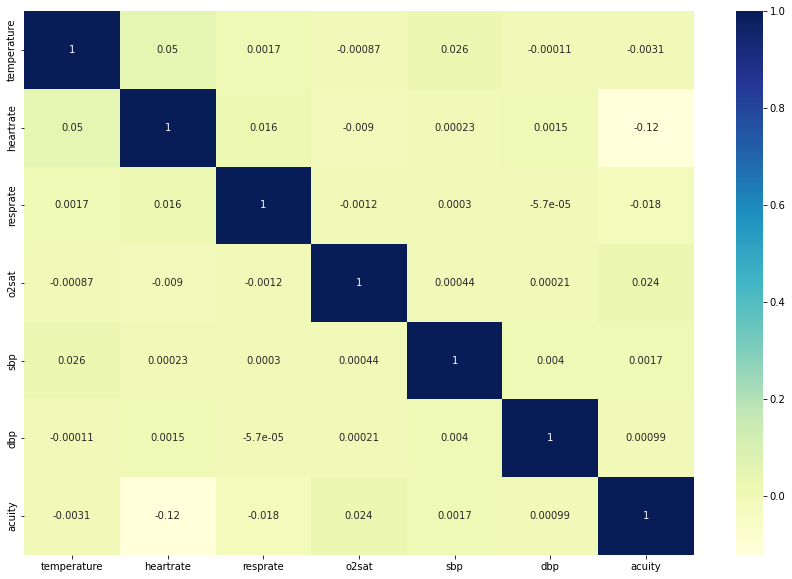

In [39]:
plt.figure(figsize=(15, 10))

sns.heatmap(edstay_ad[lst_col].corr(), cmap="YlGnBu", annot=True)


## 2.2 Diagnostic table

In [40]:
diagnosis = pd.read_csv('raw/diagnosis.csv')

In [41]:
icd_conversion = pd.read_csv('raw/icd9toicd10cmgem.csv')

In [42]:
diagnosis_1 = pd.merge(diagnosis,icd_conversion[['icd9cm','icd10cm']],how='left',left_on='icd_code',right_on='icd9cm')

In [43]:
diagnosis_1[(diagnosis_1.icd_version == 9) & (diagnosis_1['icd10cm'].isna())].icd_code.value_counts()

7070    1045
389      904
539      302
7054     182
845      131
        ... 
9959       1
85         1
37         1
543        1
794        1
Name: icd_code, Length: 104, dtype: int64

This NA case because some code in Version9 doesn't have exactly same code in Version 10, therefore we keep icd code version 9 for these case

In [44]:
diagnosis_1['fin_code'] = diagnosis_1['icd_code']
diagnosis_1.loc[diagnosis_1.icd_version == 9, 'fin_code'] = diagnosis_1.loc[diagnosis_1.icd_version == 9,'icd10cm']
diagnosis_1.loc[diagnosis_1.fin_code.isna(),'fin_code'] = diagnosis_1.loc[diagnosis_1.fin_code.isna(),'icd_code']

In [45]:
diagnosis_1['fin_code_group'] = diagnosis_1['fin_code'].apply(lambda x: x[:3])
#create final code group which takes first 3 letter of the code

In [46]:
diagnosis_1['key'] = diagnosis_1['subject_id'].astype(str)+'_'+diagnosis_1['stay_id'].astype(str)

In [47]:
diagnosis_icdcode = diagnosis_1[['key', 'fin_code_group']].groupby(['key']).agg({'fin_code_group': lambda x: ','.join(x.unique())}).reset_index()

In [48]:
diagnosis_icdcode = pd.merge(diagnosis_icdcode,edstay_ad[['y_var','key','DateTime_in', 'subject_id','stay_id']], how = "inner", left_on="key", right_on="key")

In [49]:
def print_plot_length(df,x_var,y_var):
    def calculate_length(x):
        if type(x) == float:
            if x > 0:
                r = len(x.replace(',',' ').split())
            else: r = 0
        else:
            r = len(x.replace(',',' ').split())
        
        return(r)
    df['length'] = df[x_var].apply(calculate_length)
    positive_lengths = df[df[y_var]==1]['length']
    negative_lengths = df[df[y_var]==0]['length']
    plt.figure(figsize=(15,5))
    plt.title(x_var + ' length distribution')
    sns.distplot(negative_lengths, kde=False)
    sns.distplot(positive_lengths, kde=False)
    plt.legend(['home', 'admitted'])
    plt.xlabel('no of icd group')
    plt.ylabel('no of observations')
    plt.grid(False)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


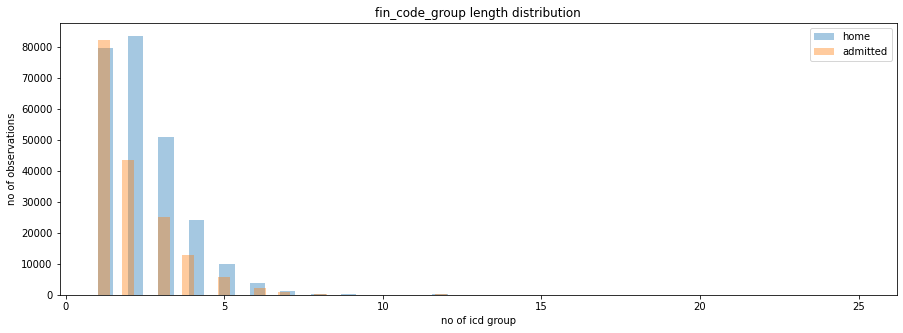

In [50]:
print_plot_length(diagnosis_icdcode,'fin_code_group','y_var')

In [51]:
diagnosis_icdcode['fin_code_group'] = diagnosis_icdcode['fin_code_group'].str.split(',')

In [52]:
data_2 = diagnosis_icdcode.sort_values(by = ['subject_id','DateTime_in'], ascending=True).reset_index(drop=True)

In [53]:
dict2 = {}

for i in range(len(data_2)):
    if i == 0:
        dict2[i] = []
        
    else:
        if (i > 0) & (type(data_2['fin_code_group'][i-1])== list):
            if (data_2['subject_id'][i] == data_2['subject_id'][i-1]):
                dict2[i] = []
                dict2[i].extend(list(data_2['fin_code_group'][i-1]))         
            else:
                dict2[i] = []
                
        else:
            dict2[i] = []

In [54]:
for i in range(len(dict2)):
    dict2[i] = ','.join(dict2[i])

In [55]:
df = pd.DataFrame.from_dict(dict2,orient = 'index',columns=['his_icd_code'])


In [56]:
diagnosis_his = pd.merge(data_2, df, how = 'inner',left_index=True, right_index=True) 

In [57]:
diagnosis_his[:10]

,key,fin_code_group,y_var,DateTime_in,subject_id,stay_id,length,his_icd_code
0,10000032_33258284,"[K72, R18, 707, Z21]",1,2180-05-06 19:17:00,10000032,33258284,4,
1,10000032_38112554,"[R18, 707, K74, Z21]",1,2180-06-26 15:54:00,10000032,38112554,4,"K72,R18,707,Z21"
2,10000032_32952584,"[I95, 707, Z21]",0,2180-07-22 16:24:00,10000032,32952584,3,"R18,707,K74,Z21"
3,10000032_39399961,"[R41, G93]",1,2180-07-23 05:54:00,10000032,39399961,2,"I95,707,Z21"
4,10000032_35968195,"[K74, R10, Z21]",1,2180-08-05 20:58:00,10000032,35968195,3,"R41,G93"
5,10000084_35203156,"[R53, G20]",1,2160-11-20 20:36:00,10000084,35203156,2,
6,10000084_36954971,"[R41, F03]",0,2160-12-27 18:32:00,10000084,36954971,2,"R53,G20"
7,10000108_32522732,[R22],0,2163-09-16 16:34:00,10000108,32522732,1,
8,10000108_39513268,[K12],0,2163-09-24 16:14:00,10000108,39513268,1,R22
9,10000108_36533795,[K12],0,2163-09-27 16:18:00,10000108,36533795,1,K12


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


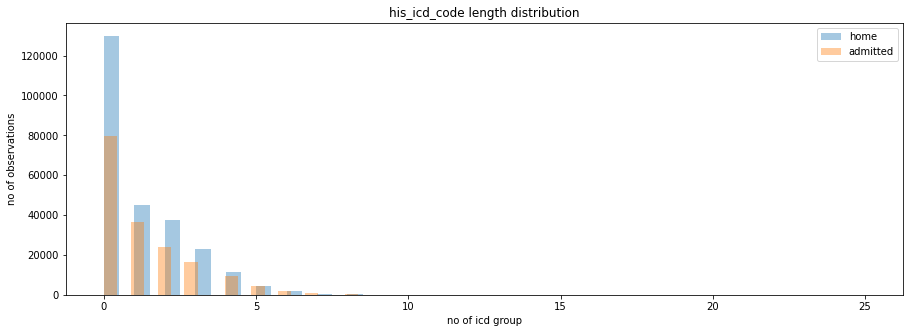

In [58]:
print_plot_length(diagnosis_his,'his_icd_code','y_var')

# 3. Transform data

## 3.1 Non-text data

In [59]:
edstay_ad1 = edstay_ad.drop(['subject_id','hadm_id','stay_id','intime','outtime','race', 'gender','race_color','disposition','y_var_adm_text','key', 'DateTime_in', 'DateTime_out','stay','historical_stay_length','chiefcomplaint', 'pain', 'y_var'], axis = 1)

In [60]:
edstay_ad1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428284 entries, 0 to 428283
Data columns (total 11 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   arrival_transport              428284 non-null  object 
 1   temperature                    405762 non-null  float64
 2   heartrate                      412132 non-null  float64
 3   resprate                       408822 non-null  float64
 4   o2sat                          408594 non-null  float64
 5   sbp                            410935 non-null  float64
 6   dbp                            410124 non-null  float64
 7   acuity                         422216 non-null  float64
 8   intime_h                       428284 non-null  int64  
 9   historical_stay_status         428284 non-null  object 
 10  historical_stay_length_in_day  428284 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 39.2+ MB


In [61]:
updated_edstay_ad = edstay_ad1
updated_edstay_ad['temperaturemissing'] = updated_edstay_ad['temperature'].isnull().astype(int)
updated_edstay_ad['heartratemissing'] = updated_edstay_ad['heartrate'].isnull().astype(int)
updated_edstay_ad['respratemissing'] = updated_edstay_ad['resprate'].isnull().astype(int)
updated_edstay_ad['o2satmissing'] = updated_edstay_ad['o2sat'].isnull().astype(int)
updated_edstay_ad['sbpmissing'] = updated_edstay_ad['sbp'].isnull().astype(int)
updated_edstay_ad['dbpmissing'] = updated_edstay_ad['dbp'].isnull().astype(int)
updated_edstay_ad['acuitymissing'] = updated_edstay_ad['acuity'].isnull().astype(int)

In [62]:
num_attr = edstay_ad1.select_dtypes(include=['float64', 'int64']).columns
cat_attr = edstay_ad1.select_dtypes(include=['O']).columns
#bool_attr = edstay_ad.select_dtypes(include=['bool']).columns

In [63]:
my_imputer = SimpleImputer(strategy = 'median')
updated_edstay_ad[num_attr] = my_imputer.fit_transform(updated_edstay_ad[num_attr])
updated_edstay_ad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428284 entries, 0 to 428283
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   arrival_transport              428284 non-null  object 
 1   temperature                    428284 non-null  float64
 2   heartrate                      428284 non-null  float64
 3   resprate                       428284 non-null  float64
 4   o2sat                          428284 non-null  float64
 5   sbp                            428284 non-null  float64
 6   dbp                            428284 non-null  float64
 7   acuity                         428284 non-null  float64
 8   intime_h                       428284 non-null  float64
 9   historical_stay_status         428284 non-null  object 
 10  historical_stay_length_in_day  428284 non-null  float64
 11  temperaturemissing             428284 non-null  float64
 12  heartratemissing              

In [64]:
trans_pip = ColumnTransformer([
    ("num",StandardScaler(), num_attr),
    ("cat",OneHotEncoder(),cat_attr)
],remainder='passthrough')

## 3.2 Chiefcomplaint

In [65]:
triage_2 = edstay_ad[['subject_id','stay_id', 'y_var','chiefcomplaint']]

In [66]:
triage_2[triage_2.y_var.isna()]

,subject_id,stay_id,y_var,chiefcomplaint


In [67]:
triage_2[triage_2.chiefcomplaint.isna()]

,subject_id,stay_id,y_var,chiefcomplaint
209834,14913519,33280070,1,NaN
219040,15127661,39766508,1,NaN
230046,15376111,34216718,1,NaN
241580,15632852,37860864,0,NaN
307992,17192157,31192693,0,NaN
322362,17526143,30744048,1,NaN
356784,18321345,37024607,1,NaN
360935,18425846,33948058,1,NaN


In [68]:
triage_2.loc[triage_2['chiefcomplaint'].isna(),'chiefcomplaint'] = ''

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [69]:
triage_2[triage_2['chiefcomplaint'].isna()]

,subject_id,stay_id,y_var,chiefcomplaint


In [70]:
# Preprocess the job_description (remove the weird part of strings)
def preprocess_text(text):
    if type(text) == float:
        return text
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
    
triage_2.chiefcomplaint = triage_2.chiefcomplaint.apply(preprocess_text)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [71]:
#df_pre_icd_full = pd.read_csv('previous_icd_code.csv')

triage_3 = pd.merge(triage_2,diagnosis_his[['his_icd_code', 'subject_id', 'stay_id']], how = "left",on=['subject_id', 'stay_id'])

In [72]:
triage_3

,subject_id,stay_id,y_var,chiefcomplaint,his_icd_code
0,10000032,33258284,1,"abd pain , abdominal distention",
1,10000032,38112554,1,abdominal distention,"K72,R18,707,Z21"
2,10000032,35968195,1,"n v d , abd pain","R41,G93"
3,10000032,32952584,0,hypotension,"R18,707,K74,Z21"
4,10000032,39399961,1,"abdominal distention , abd pain , lethagic","I95,707,Z21"
...,...,...,...,...,...
428279,19999784,34149746,1,wound eval,R53
428280,19999784,35692999,1,l leg weakness,
428281,19999828,32917002,1,"abd pain , wound eval",K63
428282,19999828,30712109,1,"abd pain , wound eval",


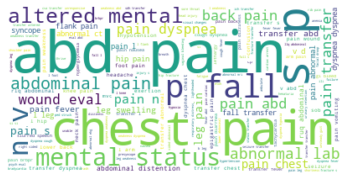

In [73]:
#filter the df to one candidate, and create a list of responses from them
text = triage_3[triage_3.y_var==1].chiefcomplaint.tolist() 

# join the list and lowercase all the words
text = ' '.join(text).lower()

#create the wordcloud object
wordcloud = WordCloud(stopwords = STOPWORDS, collocations=True,background_color = "white").generate(text)

#plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

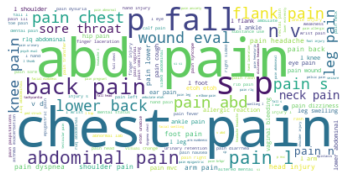

In [74]:
#filter the df to one candidate, and create a list of responses from them
text = triage_3[triage_3.y_var==0].chiefcomplaint.tolist() 

# join the list and lowercase all the words
text = ' '.join(text).lower()

#create the wordcloud object
wordcloud = WordCloud(stopwords = STOPWORDS, collocations=True,background_color = "white").generate(text)

#plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

Calculate log odds ratio to find top keyword for each diposition:

log2{
  [(frequency of the word for diposition status_i + 1) /  (total of word count for diposition status_i + 1)] 
  / 
  [(frequency of that word for other diposition status +1)/  (total of word count for other diposition status + 1)]
}

In [75]:

# create a list of diposition status
out_come = triage_3.y_var.unique()
#create a list of responses for diposition status using a list comprehension
corpus = [' '.join(triage_3[(triage_3.y_var==i)].chiefcomplaint.tolist()) for i in out_come]

# import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#instantiate a CountVectorizer object
# utilize the new STOP_WORDS list
cv=CountVectorizer(ngram_range=(1, 3))

# fit transform our text and create a dataframe with the result
X = cv.fit_transform(corpus)
X = X.toarray()

bow=pd.DataFrame(X, columns = cv.get_feature_names())
bow.index=out_come

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [76]:
bow

,aaa,aaa aaa,aaa aaa abd,aaa aaa facial,aaa aaa leak,aaa aaa transfer,aaa abd,aaa abd pain,aaa abdominal,aaa abdominal pain,...,zoster visual,zoster visual changes,zoster wound,zoster wound eval,zygoma,zygoma fracture,zygoma fracture chest,zygomatic,zygomatic fx,zygomatic fx neck
1,206,5,1,1,1,2,15,15,3,3,...,0,0,0,0,0,0,0,0,0,0
0,22,0,0,0,0,0,3,3,0,0,...,1,1,1,1,1,1,1,1,1,1


In [77]:
from tqdm import tqdm #used for progress bar
import math

#build an empty dataframe
t_bow_df=pd.DataFrame()

# By each diposition, divide the number of times a word is collected(frequency)
bow_transformed = bow.apply(lambda x: (x+1)/ (bow.loc[x.name].sum()+1), axis=1) 

for i in tqdm(out_come):
    feat_s = bow[bow.index != i].sum()+1 #sum all the times each word excluding the diposition status_i
    feat_s_all = np.sum(bow[bow.index != i].sum()) # all the total words , excluding the diposition status_i
    tot = feat_s / feat_s_all #find the frequency of words said among other diposition
    row = bow_transformed.loc[i] / tot #divide the diposition status_i's array of frequency of words by all other diposition status's frequency
    row = pd.DataFrame(row).T #create a df, and transform
    results = row.apply(lambda x: math.log(x,2)) #take the log of each frequency
    
    t_bow_df = pd.concat([t_bow_df, pd.DataFrame([results], index=[i])]) #append to df


100%|██████████| 2/2 [00:30<00:00, 15.29s/it]


In [78]:
bow_transformed

,aaa,aaa aaa,aaa aaa abd,aaa aaa facial,aaa aaa leak,aaa aaa transfer,aaa abd,aaa abd pain,aaa abdominal,aaa abdominal pain,...,zoster visual,zoster visual changes,zoster wound,zoster wound eval,zygoma,zygoma fracture,zygoma fracture chest,zygomatic,zygomatic fx,zygomatic fx neck
1,0.000178,5.154024e-06,1.718008e-06,1.718008e-06,1.718008e-06,2.577012e-06,0.000014,0.000014,3.436016e-06,3.436016e-06,...,8.590040e-07,8.590040e-07,8.590040e-07,8.590040e-07,8.590040e-07,8.590040e-07,8.590040e-07,8.590040e-07,8.590040e-07,8.590040e-07
0,0.000014,5.983739e-07,5.983739e-07,5.983739e-07,5.983739e-07,5.983739e-07,0.000002,0.000002,5.983739e-07,5.983739e-07,...,1.196748e-06,1.196748e-06,1.196748e-06,1.196748e-06,1.196748e-06,1.196748e-06,1.196748e-06,1.196748e-06,1.196748e-06,1.196748e-06


In [79]:
t_bow_df.loc[1].sort_values(ascending=False)[:10]


intubated                   8.671364
transfer cva                7.896656
cva transfer                7.731070
transfer ich transfer       7.060776
intubated transfer          7.013470
transfer dyspnea dyspnea    6.981048
urosepsis                   6.947882
pain nstemi transfer        6.879169
chest pain nstemi           6.750435
pain cva transfer           6.731070
Name: 1, dtype: float64

In [80]:
text=t_bow_df.loc[1].sort_values(ascending=False)[:5000]
text1_dict={k: v for k, v in sorted(text.items(),reverse=True, key=lambda item: item[1])}


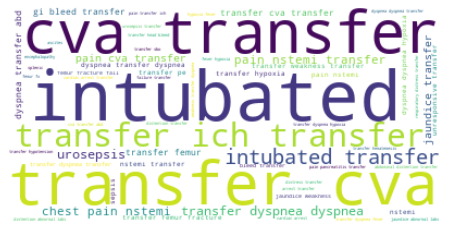

In [81]:
wordcloud = WordCloud(min_word_length =3,
                      background_color='white').generate_from_frequencies(text1_dict)

plt.figure(figsize=(8,4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [82]:
text=t_bow_df.loc[0].sort_values(ascending=False)[:5000]
text0_dict={k: v for k, v in sorted(text.items(),reverse=True, key=lambda item: item[1])}


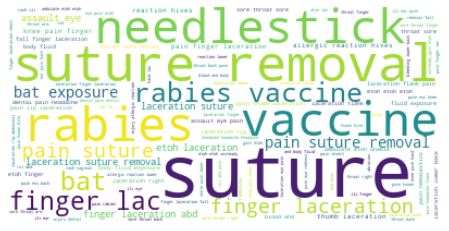

In [83]:
wordcloud = WordCloud(min_word_length =3,
                      background_color='white').generate_from_frequencies(text0_dict)

plt.figure(figsize=(8,4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [84]:
def print_plot_length(df,x_var,y_var):
    def calculate_length(x):
        if type(x) == float:
            if x > 0:
                r = len(x.replace(',',' ').split())
            else: r = 0
        else:
            r = len(x.replace(',',' ').split())
        
        return(r)
    df['length'] = df[x_var].apply(calculate_length)
    positive_lengths = df[df[y_var]==1]['length']
    negative_lengths = df[df[y_var]==0]['length']
    plt.figure(figsize=(15,5))
    plt.title(x_var + ' length distribution')
    sns.distplot(negative_lengths, kde=False)
    sns.distplot(positive_lengths, kde=False)
    plt.legend(['home', 'admitted'])
    plt.xlabel('no of words')
    plt.ylabel('no of observations')
    plt.grid(False)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


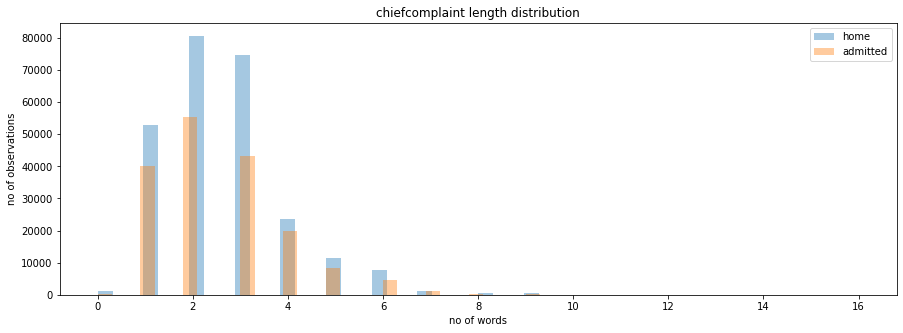

In [85]:
print_plot_length(triage_3,'chiefcomplaint','y_var')

## 3.3 Historical icd code

In [86]:
df1 = diagnosis_his[['key', 'y_var', 'his_icd_code']]

In [87]:
type(df1['his_icd_code'][0])

str

In [88]:
df1['his_icd_code'] = df1['his_icd_code'].str.split(',')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [89]:
df = df1.explode('his_icd_code')

In [90]:
df

,key,y_var,his_icd_code
0,10000032_33258284,1,
1,10000032_38112554,1,K72
1,10000032_38112554,1,R18
1,10000032_38112554,1,707
1,10000032_38112554,1,Z21
...,...,...,...
427258,19999784_37972930,1,R53
427259,19999784_34149746,1,R53
427260,19999828_30712109,1,
427261,19999828_32917002,1,K63


In [91]:
df = df[df.his_icd_code != '']
df = df.reset_index()

In [92]:
df

,index,key,y_var,his_icd_code
0,1,10000032_38112554,1,K72
1,1,10000032_38112554,1,R18
2,1,10000032_38112554,1,707
3,1,10000032_38112554,1,Z21
4,2,10000032_32952584,0,R18
...,...,...,...,...
492059,427247,19999287_37929752,1,R09
492060,427247,19999287_37929752,1,J44
492061,427258,19999784_37972930,1,R53
492062,427259,19999784_34149746,1,R53


In [93]:
cat_encoder = OneHotEncoder()
diagnosis_1_transformed = cat_encoder.fit_transform(df[['his_icd_code']])
diagnosis_1_transformed.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [94]:
icd_trans = diagnosis_1_transformed.toarray()

In [95]:
dict_diag = {}

for i in range(len(df)):
    if i == 0:
        dict_diag[df['key'][i]] = icd_trans[i]
    else:
        if df['key'][i] != df['key'][i-1]:
            dict_diag[df['key'][i]] = icd_trans[i]
        else: 
            dict_diag[df['key'][i]] = icd_trans[i] + dict_diag.get(df['key'][i])

In [96]:
y_value = df[['key','y_var']].drop_duplicates(ignore_index=True)

In [97]:
y_value

,key,y_var
0,10000032_38112554,1
1,10000032_32952584,0
2,10000032_39399961,1
3,10000032_35968195,1
4,10000084_36954971,0
...,...,...
217887,19999270_36263682,0
217888,19999287_37929752,1
217889,19999784_37972930,1
217890,19999784_34149746,1


In [98]:
X = np.array(list(dict_diag.values()))
Y_lst = y_value.y_var.tolist()

In [99]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X, Y_lst)

SelectKBest(k='all', score_func=<function chi2 at 0x7fa10d55d8c0>)

In [100]:
for i in range(len(fs.scores_)):
	print('Feature %s: %f' % (cat_encoder.categories_[0][i], fs.scores_[i]))

Feature 119: 5.305957
Feature 312: 0.040179
Feature 341: 0.753870
Feature 35: 1.326489
Feature 37: 0.753870
Feature 389: 196.182691
Feature 400: 0.040179
Feature 410: 0.040179
Feature 411: 0.022644
Feature 417: 0.080359
Feature 418: 1.145330
Feature 419: 12.484121
Feature 42: 11.365538
Feature 478: 1.326489
Feature 479: 0.687840
Feature 498: 1.326489
Feature 529: 0.527829
Feature 530: 1.326489
Feature 531: 1.698123
Feature 532: 0.108453
Feature 539: 3.126718
Feature 541: 4.804549
Feature 544: 0.080359
Feature 546: 0.098143
Feature 549: 4.040322
Feature 579: 0.593243
Feature 59: 2.261609
Feature 703: 0.080359
Feature 705: 62.770096
Feature 707: 14.802431
Feature 709: 0.040179
Feature 71: 0.753870
Feature 74: 3.979468
Feature 740: 0.040179
Feature 743: 0.753870
Feature 75: 2.153720
Feature 780: 0.753870
Feature 781: 0.753870
Feature 785: 3.979468
Feature 799: 2.261609
Feature 844: 0.753870
Feature 845: 8.048250
Feature 846: 0.686609
Feature 85: 1.326489
Feature 863: 0.527829
Feature 88: 

Text(0, 0.5, 'Number of icd_group')

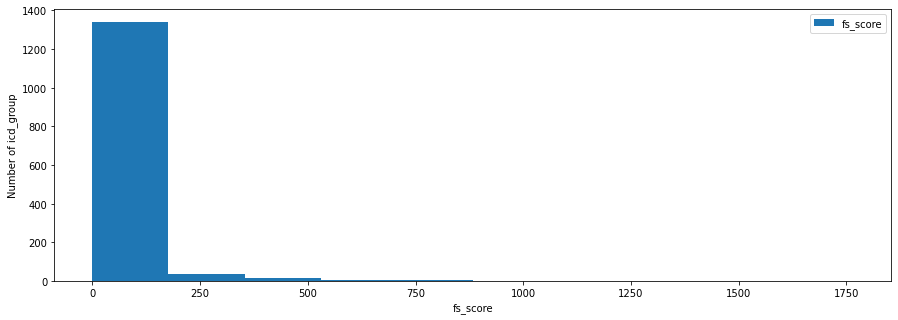

In [101]:
dict_icd_fs_chi2 = {}
for i in range(len(fs.scores_)):
	dict_icd_fs_chi2[cat_encoder.categories_[0][i]]= fs.scores_[i]

df1 = pd.DataFrame.from_dict(dict_icd_fs_chi2,orient = 'index',columns=['fs_score'])
df1['icd_group'] = df1.index

df1 = df1.dropna()
df1 = df1.sort_values(by='fs_score',ascending=False).reset_index(drop=True)

ax = df1.plot.hist("fs_score",figsize=(15,5))
ax.set_xlabel("fs_score")
ax.set_ylabel("Number of icd_group")

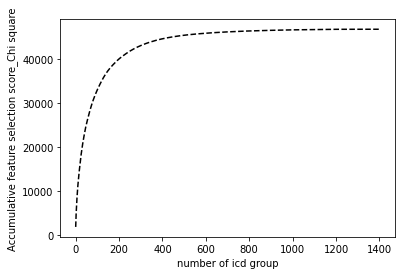

In [102]:
plt.plot(np.array(df1.fs_score).cumsum(), 'k--')
plt.ylabel('Accumulative feature selection score_Chi square')
plt.xlabel('number of icd group')
plt.show()

In [103]:
model_tree = ExtraTreesClassifier(bootstrap = True,n_jobs = -1,random_state = 123, min_samples_leaf=100)
model_tree.fit(X, Y_lst)

ExtraTreesClassifier(bootstrap=True, min_samples_leaf=100, n_jobs=-1,
                     random_state=123)

Text(0, 0.5, 'Number of icd_group')

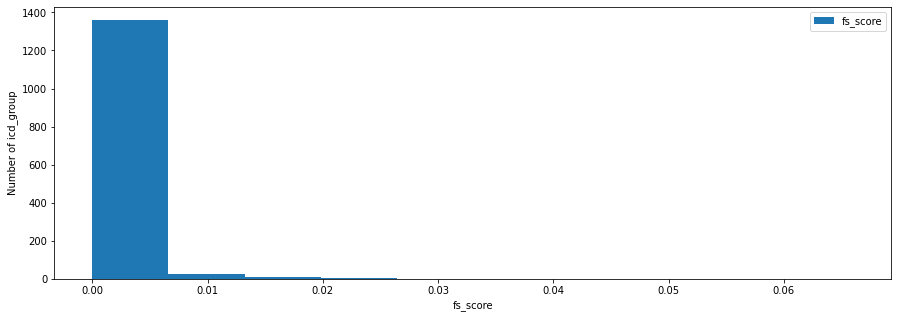

In [104]:
dict_icd_fs_extratree = {}
for i in range(len(model_tree.feature_importances_)):
	dict_icd_fs_extratree[cat_encoder.categories_[0][i]]= model_tree.feature_importances_[i]


df1 = pd.DataFrame.from_dict(dict_icd_fs_extratree,orient = 'index',columns=['fs_score'])
df1['icd_group'] = df1.index

#df1.to_csv('icd_extratreefs.csv')
df1 = df1.sort_values(by='fs_score',ascending=False).reset_index(drop=True)

ax = df1.plot.hist("fs_score",figsize=(15,5))
ax.set_xlabel("fs_score")
ax.set_ylabel("Number of icd_group")

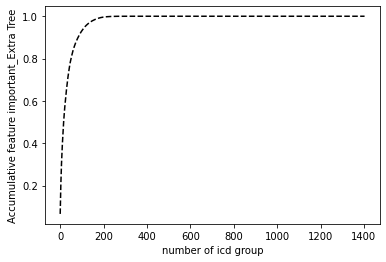

In [105]:
plt.plot(np.array(df1.fs_score).cumsum(), 'k--')
plt.ylabel('Accumulative feature important_Extra Tree')
plt.xlabel('number of icd group')
plt.show()

In [106]:
df1 = pd.DataFrame.from_dict(dict_icd_fs_chi2,orient = 'index',columns=['fs_score'])
df1['icd_group'] = df1.index
df1 = df1.dropna()

df2 = pd.DataFrame.from_dict(dict_icd_fs_extratree,orient = 'index',columns=['fs_score'])
df2['icd_group'] = df2.index

df_his_icd = pd.merge(df1,df2, how='inner', left_on = 'icd_group', right_on='icd_group')

df_his_icd = df_his_icd.sort_values(by = ['fs_score_x', 'fs_score_y'], ascending=False).reset_index(drop=True)

In [107]:
his_icd_top198 = df_his_icd['icd_group'][:198]

# 4. XG boost

In [192]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [193]:
seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(updated_edstay_ad, triage_3.y_var, test_size=test_size, random_state=seed,
                                                   stratify=triage_3.y_var)

In [212]:
X_train_trans = trans_pip.fit_transform(X_train)

In [214]:
feature_names = list(trans_pip.get_feature_names_out())

In [216]:
X_train_trans = pd.DataFrame(X_train_trans, columns = feature_names)

In [217]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_trans, y_train)

XGBClassifier()

In [220]:
X_test_trans = trans_pip.transform(X_test)
X_test_trans = pd.DataFrame(X_test_trans, columns = feature_names)

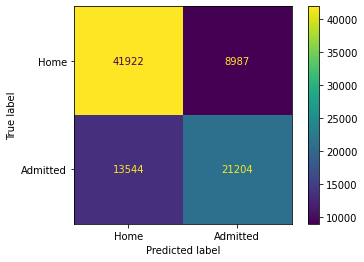

In [221]:
disp = ConfusionMatrixDisplay.from_estimator(model_xgb,X_test_trans, y_test, display_labels = ["Home","Admitted"], values_format = '.5g')


In [222]:
pred_probs = model_xgb.predict_proba(X_test_trans)
pred_probs = [x[1] for x in pred_probs]
preds = model_xgb.predict(X_test_trans)

In [223]:
print("roc auc for test set:", roc_auc_score(y_test, pred_probs))
print("accuracy score for test set:", accuracy_score(y_test, preds))
print("classification_report for test set:")
print(classification_report(y_test, preds))
print("f1 score for test set:", f1_score(y_test, preds))


roc auc for test set: 0.8040270048343154
accuracy score for test set: 0.7369625366286469
classification_report for test set:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79     50909
           1       0.70      0.61      0.65     34748

    accuracy                           0.74     85657
   macro avg       0.73      0.72      0.72     85657
weighted avg       0.73      0.74      0.73     85657

f1 score for test set: 0.6530436255562913


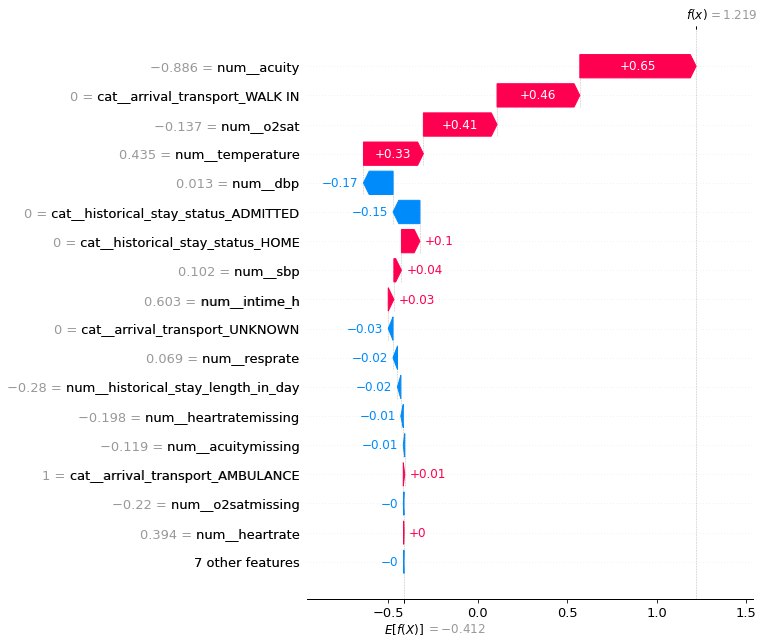

In [225]:
import shap
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_train_trans)

shap.plots.waterfall(shap_values[0], max_display=len(X_train.columns))

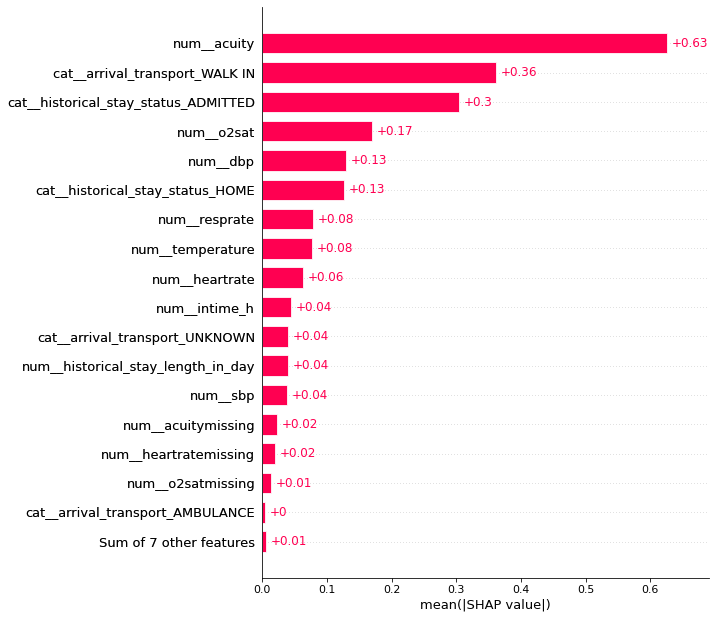

In [226]:
shap.plots.bar(shap_values, max_display=len(X_train.columns))

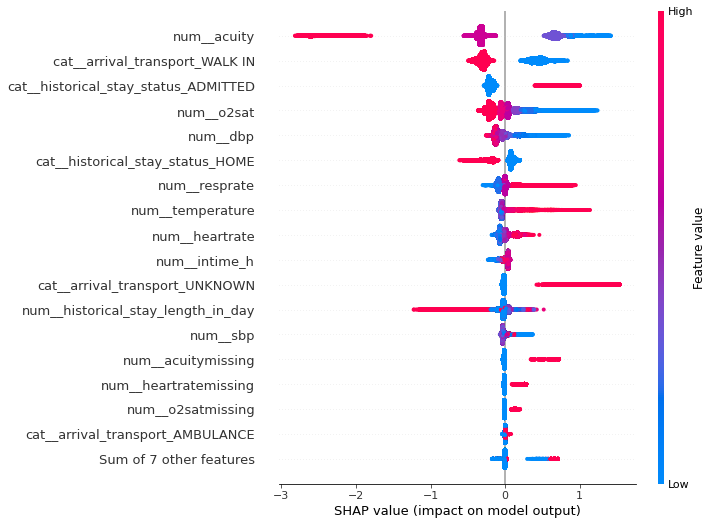

In [227]:
shap.plots.beeswarm(shap_values, max_display=len(X_train.columns))

# 5. Random forest

In [228]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(min_samples_split = 100, random_state=0, class_weight = "balanced", bootstrap = True)

clf.fit(X_train_trans, y_train)




RandomForestClassifier(class_weight='balanced', min_samples_split=100,
                       random_state=0)

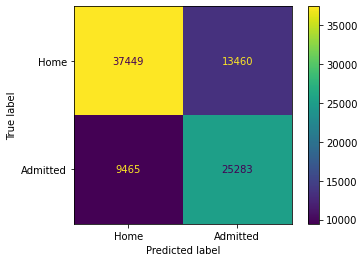

In [229]:
disp = ConfusionMatrixDisplay.from_estimator(clf,X_test_trans, y_test, display_labels = ["Home","Admitted"], values_format = '.5g')

In [230]:
preds = clf.predict(X_test_trans)
pred_probs = clf.predict_proba(X_test_trans)

In [231]:
pred_probs_dt = [list(i)[1] for i in pred_probs]


In [233]:
print("roc auc for test set:", roc_auc_score(y_test, pred_probs_dt))
print("accuracy score for test set:", accuracy_score(y_test, preds))
print("classification_report for test set:")
print(classification_report(y_test, preds))
print("f1 score for test set:", f1_score(y_test, preds))


roc auc for test set: 0.8055707127014055
accuracy score for test set: 0.7323627958018609
classification_report for test set:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77     50909
           1       0.65      0.73      0.69     34748

    accuracy                           0.73     85657
   macro avg       0.73      0.73      0.73     85657
weighted avg       0.74      0.73      0.73     85657

f1 score for test set: 0.6880570409982175


In [234]:
importances = clf.feature_importances_
sorted_idx = importances.argsort()

<BarContainer object of 24 artists>

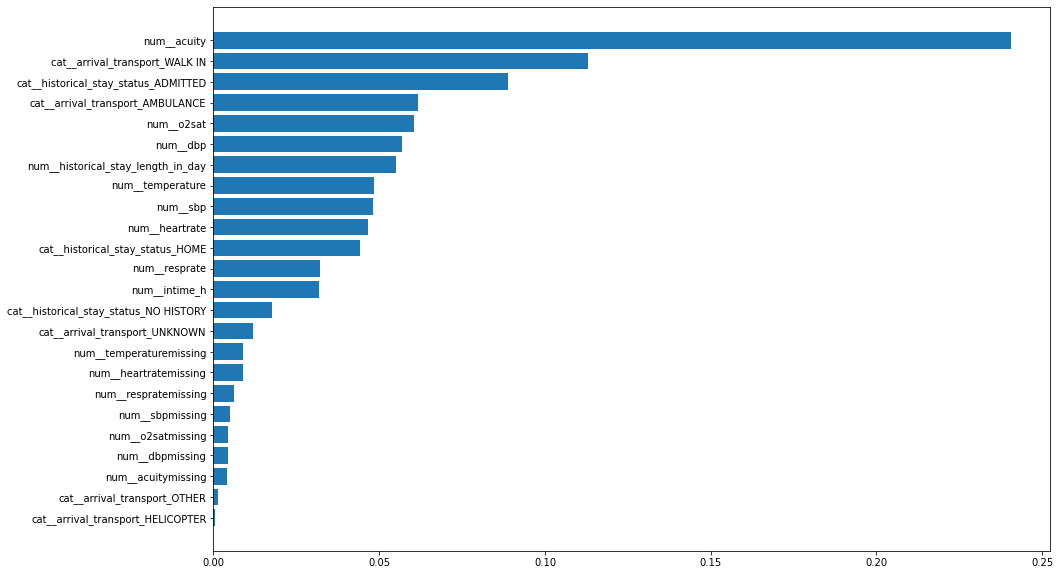

In [238]:
plt.figure(figsize=(15,10))
plt.barh(X_train_trans.columns[sorted_idx], importances[sorted_idx])


In [239]:
explainer = shap.TreeExplainer(clf)


In [240]:
shap_values = explainer.shap_values(X_test_trans[:500])

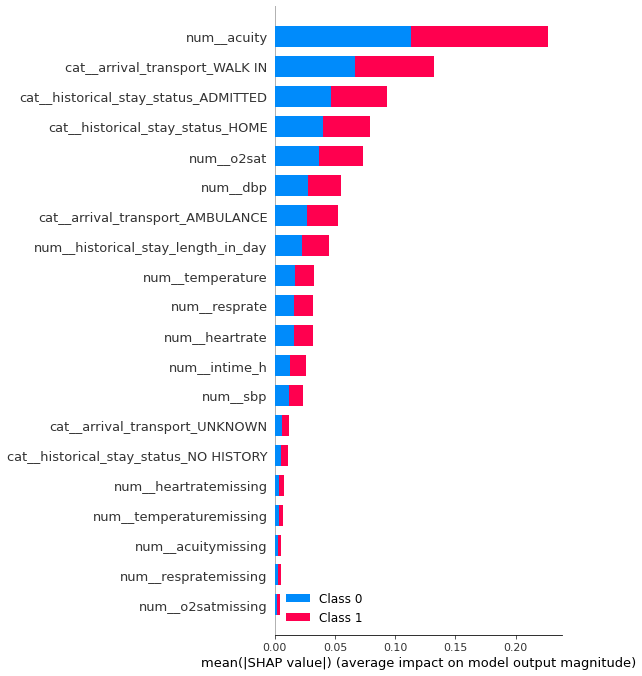

In [241]:
shap.summary_plot(shap_values, X_test_trans[:500], feature_names = X_train_trans.columns)

# 7.Logistic regression

In [130]:
from sklearn.linear_model import LogisticRegression

In [131]:
seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(updated_edstay_ad, triage_3.y_var, test_size=test_size, random_state=seed,
                                                   stratify=Y)

In [132]:
X_train_trans = trans_pip.fit_transform(X_train)

In [133]:
lo = LogisticRegression(random_state=0).fit(X_train_trans, y_train)

In [134]:
X_test_trans = trans_pip.transform(X_test)

In [135]:
preds = lo.predict(X_test_trans)
pred_probs = lo.predict_proba(X_test_trans)

In [136]:
pred_probs_lo = [list(i)[1] for i in pred_probs]


In [137]:
print("roc auc for test set:", roc_auc_score(y_test, pred_probs_lo))
print("accuracy score for test set:", accuracy_score(y_test, preds))
print("classification_report for test set:")
print(classification_report(y_test, preds))
print("f1 score for test set:", f1_score(y_test, preds))


roc auc for test set: 0.787168306604713
accuracy score for test set: 0.721715679979453
classification_report for test set:
              precision    recall  f1-score   support

           0       0.74      0.83      0.78     50909
           1       0.69      0.57      0.62     34748

    accuracy                           0.72     85657
   macro avg       0.71      0.70      0.70     85657
weighted avg       0.72      0.72      0.72     85657

f1 score for test set: 0.6237906598696358


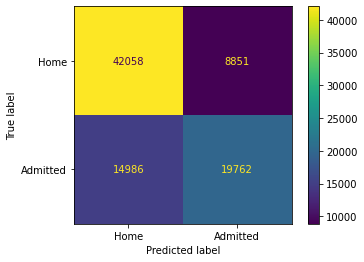

In [138]:
disp = ConfusionMatrixDisplay.from_estimator(lo,X_test_trans, y_test, display_labels = ["Home","Admitted"], values_format = '.5g')

In [139]:
lo_coef = abs(lo.coef_)

In [140]:
feature_names = np.array(trans_pip.get_feature_names_out())


In [141]:
sorted_idx = lo_coef[0].argsort()

<BarContainer object of 24 artists>

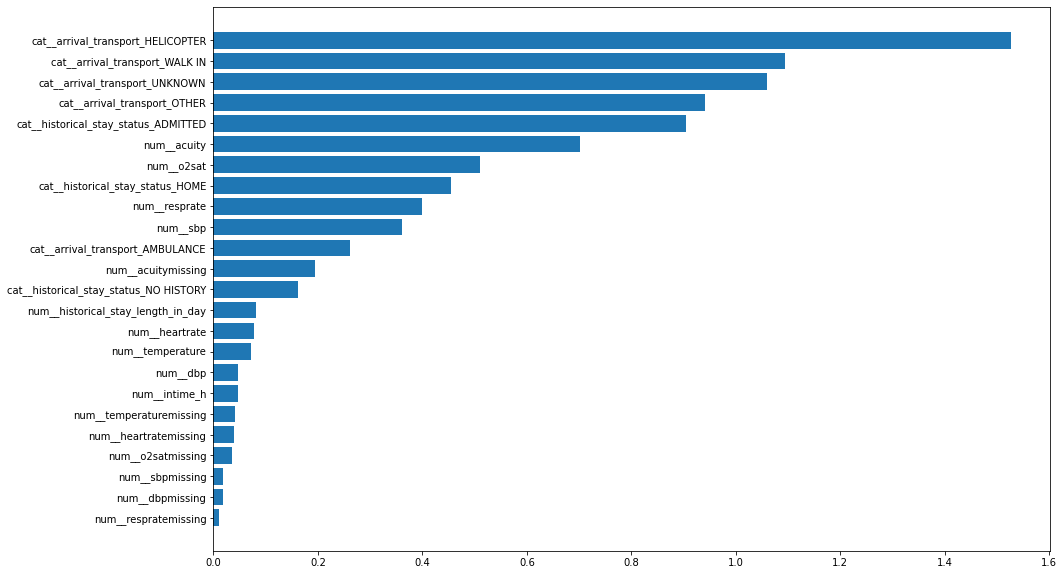

In [142]:
plt.figure(figsize=(15,10))
plt.barh(feature_names[sorted_idx], lo_coef[0][sorted_idx])


# 8. Deep neural networks

## 8.1 Split dataset

In [143]:
#set random index, create train set and validation set from the original train set

#create array of random index
np.random.seed(123)
ind = np.arange(len(triage_3))
np.random.shuffle(ind)
#create testing index  = 0 to 0.20 * random index
test_index = ind[:int(len(triage_3) * 0.20)]
#create val index  = 0.20 to 0.30 * random index
val_index = ind[int(len(triage_3) * 0.20):int(len(triage_3) * 0.30)]
#create train index = 0.30 * random index to end
train_index = ind[int(len(triage_3) * 0.30):]

In [144]:
train_samples_chief =  triage_3.chiefcomplaint[train_index]
train_samples_his =  triage_3.his_icd_code[train_index]
val_samples_chief =  triage_3.chiefcomplaint[val_index]
val_samples_his =  triage_3.his_icd_code[val_index]
test_samples_chief =  triage_3.chiefcomplaint[test_index]
test_samples_his =  triage_3.his_icd_code[test_index]
train_samples_o =  updated_edstay_ad.iloc[train_index]
val_samples_o =  updated_edstay_ad.iloc[val_index]
test_samples_o =  updated_edstay_ad.iloc[test_index]
train_labels =  triage_3.y_var[train_index]
val_labels = triage_3.y_var[val_index]
test_labels = triage_3.y_var[test_index]

## 8.2 Embedding for chief complaint and historical icd code

### 8.2.1 Embedding for chief complaint

In [145]:
vectorizer = TextVectorization(output_sequence_length=5)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples_chief).batch(128)
vectorizer.adapt(text_ds)

In [146]:
#print top 5 words
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'pain', 'abd', 'l']

In [147]:
#example of vectorizing a sentences:
output = vectorizer([["Abd pain, Wound eval"]])
output.numpy()[0, :6]

array([ 3,  2, 28, 20,  0])

In [148]:
#build vocabulary dictionary for chief complaint:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [149]:
#load the model w2vec for chief complaint:
model_w2v = KeyedVectors.load_word2vec_format('W2vec/BioWordVec_PubMed_MIMICIII_d200.vec.bin', binary=True)

In [150]:
num_tokens = len(voc) + 2
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    if word in model_w2v.vocab:
        embedding_vector = model_w2v.get_vector(word)
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        initializer = tf.keras.initializers.GlorotNormal(seed = 123)
        values = initializer(shape=(1, 200))
        embedding_matrix[i] = values
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 4220 words (156 misses)


In [151]:
#create embedding layers
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

### 8.2.2 Embedding for historical icd code group

In [152]:
#his_icd_top198 = pd.read_csv('top198historical_icd.csv')

In [153]:
his_icd_top198 = his_icd_top198.to_frame(name = 'icd_group')

In [154]:
vectorizer_his = TextVectorization(output_sequence_length=5)
text_ds_his = tf.data.Dataset.from_tensor_slices(his_icd_top198['icd_group']).batch(128)
vectorizer_his.adapt(text_ds_his)

In [155]:
#top 5 icd:

vectorizer_his.get_vocabulary()[:5]

['', '[UNK]', 'z99', 'z95', 'z94']

In [156]:
voc_his = vectorizer_his.get_vocabulary()
word_index_his = dict(zip(voc_his, range(len(voc_his))))
num_tokens_his = len(voc_his) + 2
embedding_dim_his = 200


# Prepare embedding matrix (create one hot encoding matrix for historical icd code)
embedding_matrix_his = np.zeros((num_tokens_his, embedding_dim_his))
for word, i in word_index_his.items():
    embedding_vector = np.zeros(embedding_dim_his)
    embedding_vector[vectorizer_his([word]).numpy()[0][0]] = 1
    embedding_matrix_his[i] = embedding_vector

In [157]:
embedding_layer_his = Embedding(
    num_tokens_his,
    embedding_dim_his,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_his),
    trainable=False,
)

### 8.3 BiGRU model using historical and current data (historical icd code & chief complaint)

In [158]:
x_train = vectorizer(np.array([[s] for s in train_samples_chief])).numpy()
x_train_his = vectorizer_his(np.array([[s] for s in train_samples_his])).numpy()
x_train_o = trans_pip.fit_transform(train_samples_o)
y_train = np.array(train_labels)

x_val = vectorizer(np.array([[s] for s in val_samples_chief])).numpy()
x_val_his = vectorizer_his(np.array([[s] for s in val_samples_his])).numpy()
x_val_o = trans_pip.transform(val_samples_o)
y_val = np.array(val_labels)



In [159]:
x_train_o.shape

(299799, 24)

In [160]:

#Optimized parameters for GRU: {'units': 114, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}
#Optimized parameters for MLP: {'units': 100/50/1, 'glorot_uniform', 0, 'relu'}

col1 = keras.Input(shape = (5,))
embedded_sequences1 = embedding_layer_his(col1)
col2 = keras.Input(shape = (5,))
embedded_sequences2 = embedding_layer(col2)
embedded_sequences = keras.layers.Concatenate(axis=1)([embedded_sequences1, embedded_sequences2])
inp3 = keras.Input(shape = (24,))

def create_mlp(dim):
  inp3 = keras.Input(shape = (dim,))
  x = keras.layers.Dense(100, kernel_initializer = 'he_normal', input_dim=dim, activation="relu")(inp3)
  x = keras.layers.Dense(64, kernel_initializer = 'he_normal', activation="relu")(x)
  #x = keras.layers.Dense(32, kernel_initializer = 'he_normal', activation="relu")(x)
  #x = keras.layers.Dense(1,  activation="sigmoid")(x)
  #preds = keras.layers.Dense(1,activation = 'sigmoid')(x)
  model = keras.models.Model(inputs = inp3, outputs = x)
  return model

def create_GRU():
  col1 = keras.Input(shape = (5,))
  col2 = keras.Input(shape = (5,))
  embedded_sequences1 = embedding_layer_his(col1)
  embedded_sequences2 = embedding_layer(col2)
  embedded_sequences = keras.layers.Concatenate(axis=1)([embedded_sequences1, embedded_sequences2])
  x = keras.layers.Bidirectional(keras.layers.GRU(114, return_sequences=True))(embedded_sequences)
  x = keras.layers.Bidirectional(keras.layers.GRU(114))(x)
  x = keras.layers.Dense(64,activation = 'relu')(x)
  #preds = keras.layers.Dense(1,activation = 'sigmoid')(x)
  model = keras.models.Model(inputs = [col1,col2], outputs = x)
  return model
  
tf.random.set_seed(42)

mlp = create_mlp(24)
gru = create_GRU()


In [161]:
combinedInput = keras.layers.concatenate([mlp.output, gru.output])
x = keras.layers.Dense(64)(combinedInput)
x = keras.layers.Dense(32)(x)
x = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.models.Model(inputs=[mlp.input, gru.input], outputs=x)


In [162]:

model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = "accuracy")
early = EarlyStopping(monitor='val_loss', patience=10)

In [163]:
from sklearn.utils import class_weight

class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y= y_train))) 

In [164]:
class_weights

{0: 0.8411113480271132, 1: 1.2328985137724846}

In [165]:
weights = {0:1-(sum(y_train)/len(y_train)),1:sum(y_train)/len(y_train)}
model.fit(x=[x_train_o,[x_train_his,x_train]], y = y_train, validation_data=([x_val_o,[x_val_his,x_val]], y_val), batch_size = 256, epochs=100, callbacks=[early],class_weight = class_weights)


Epoch 1/100
1172/1172 [==============================] - 23s 11ms/step - loss: 0.4909 - accuracy: 0.7588 - val_loss: 0.5106 - val_accuracy: 0.7655
Epoch 2/100
1172/1172 [==============================] - 11s 9ms/step - loss: 0.4755 - accuracy: 0.7677 - val_loss: 0.5071 - val_accuracy: 0.7632
Epoch 3/100
1172/1172 [==============================] - 11s 9ms/step - loss: 0.4712 - accuracy: 0.7698 - val_loss: 0.4888 - val_accuracy: 0.7743
Epoch 4/100
1172/1172 [==============================] - 11s 9ms/step - loss: 0.4686 - accuracy: 0.7714 - val_loss: 0.5029 - val_accuracy: 0.7644
Epoch 5/100
1172/1172 [==============================] - 11s 9ms/step - loss: 0.4651 - accuracy: 0.7732 - val_loss: 0.4777 - val_accuracy: 0.7727
Epoch 6/100
1172/1172 [==============================] - 11s 9ms/step - loss: 0.4633 - accuracy: 0.7741 - val_loss: 0.4804 - val_accuracy: 0.7695
Epoch 7/100
1172/1172 [==============================] - 11s 10ms/step - loss: 0.4610 - accuracy: 0.7760 - val_loss: 0.4726

In [166]:
#model.save('/content/drive/MyDrive/Capstone_project/model_3.h5')

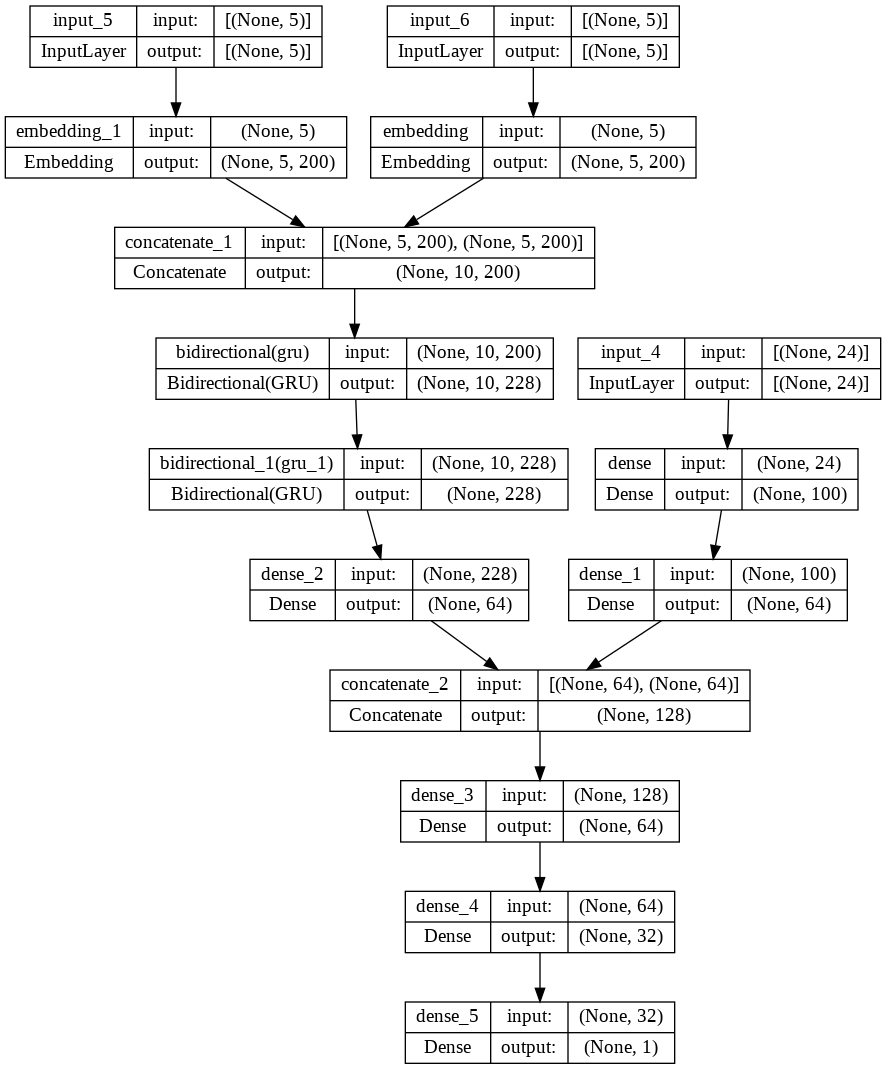

In [167]:
from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_plot_1.png', show_shapes=True, show_layer_names=True)
plot_model(model, show_shapes=True, show_layer_names=True)

### 8.4 Model testing for GRU

In [168]:
x_test = vectorizer(np.array([[s] for s in test_samples_chief])).numpy()
x_test_his = vectorizer_his(np.array([[s] for s in test_samples_his])).numpy()
x_test_o = trans_pip.transform(test_samples_o)
y_test = np.array(test_labels)

In [169]:
y_test_pred = model.predict(x=[x_test_o,x_test_his, x_test])

print("roc auc for test set:", roc_auc_score(y_test, y_test_pred))
y_pred_test_class = np.where(y_test_pred> 0.5, 1, 0)
print("accuracy score for test set:", accuracy_score(y_test, y_pred_test_class))
print("classification_report for test set:")
print(classification_report(y_test, y_pred_test_class))
print("f1 score for test set:", f1_score(y_test, y_pred_test_class))
confusion_matrix(y_test, y_pred_test_class)




2677/2677 [==============================] - 10s 3ms/step
roc auc for test set: 0.8444936865846944
accuracy score for test set: 0.7661926776874942
classification_report for test set:
              precision    recall  f1-score   support

           0       0.82      0.77      0.80     50847
           1       0.69      0.76      0.73     34809

    accuracy                           0.77     85656
   macro avg       0.76      0.77      0.76     85656
weighted avg       0.77      0.77      0.77     85656

f1 score for test set: 0.7251492486104439


array([[39210, 11637],
       [ 8390, 26419]])

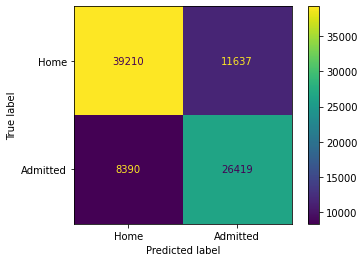

In [170]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_class), display_labels = ["Home","Admitted"])
disp.plot()
plt.show()

In [171]:
loaded_1 = keras.models.load_model("/content/drive/MyDrive/Capstone_project/model_3.h5")


In [172]:
y_test_pred = loaded_1.predict(x=[x_test_o,x_test_his, x_test])

print("roc auc for test set:", roc_auc_score(y_test, y_test_pred))
y_pred_test_class = np.where(y_test_pred> 0.5, 1, 0)
print("accuracy score for test set:", accuracy_score(y_test, y_pred_test_class))
print("classification_report for test set:")
print(classification_report(y_test, y_pred_test_class))
print("f1 score for test set:", f1_score(y_test, y_pred_test_class))
confusion_matrix(y_test, y_pred_test_class)


2677/2677 [==============================] - 10s 3ms/step
roc auc for test set: 0.8503780585850951
accuracy score for test set: 0.7707807976090408
classification_report for test set:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80     50847
           1       0.70      0.76      0.73     34809

    accuracy                           0.77     85656
   macro avg       0.76      0.77      0.77     85656
weighted avg       0.78      0.77      0.77     85656

f1 score for test set: 0.7298494730179697


array([[39500, 11347],
       [ 8287, 26522]])

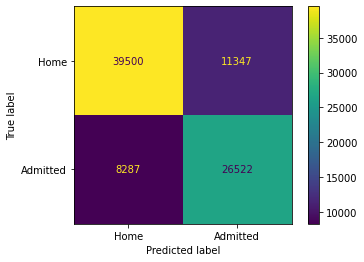

In [173]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_class), display_labels = ["Home","Admitted"])
disp.plot(values_format='')
plt.show()

In [174]:

#Optimized parameters for LSTM: {'units': 114, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}
#Optimized parameters for MLP: {'units': 100/50/1, 'glorot_uniform', 0, 'relu'}

col1 = keras.Input(shape = (5,))
embedded_sequences1 = embedding_layer_his(col1)
col2 = keras.Input(shape = (5,))
embedded_sequences2 = embedding_layer(col2)
embedded_sequences = keras.layers.Concatenate(axis=1)([embedded_sequences1, embedded_sequences2])
inp3 = keras.Input(shape = (24,))

def create_mlp(dim):
  inp3 = keras.Input(shape = (dim,))
  x = keras.layers.Dense(100, kernel_initializer = 'he_normal', input_dim=dim, activation="relu")(inp3)
  x = keras.layers.Dense(64, kernel_initializer = 'he_normal', activation="relu")(x)
  #x = keras.layers.Dense(32, kernel_initializer = 'he_normal', activation="relu")(x)
  #x = keras.layers.Dense(1,  activation="sigmoid")(x)
  #preds = keras.layers.Dense(1,activation = 'sigmoid')(x)
  model = keras.models.Model(inputs = inp3, outputs = x)
  return model

def create_LSTM():
  col1 = keras.Input(shape = (5,))
  col2 = keras.Input(shape = (5,))
  embedded_sequences1 = embedding_layer_his(col1)
  embedded_sequences2 = embedding_layer(col2)
  embedded_sequences = keras.layers.Concatenate(axis=1)([embedded_sequences1, embedded_sequences2])
  x = keras.layers.Bidirectional(keras.layers.LSTM(114, return_sequences=True))(embedded_sequences)
  x = keras.layers.Bidirectional(keras.layers.LSTM(114))(x)
  x = keras.layers.Dense(64,activation = 'relu')(x)
  #preds = keras.layers.Dense(1,activation = 'sigmoid')(x)
  model = keras.models.Model(inputs = [col1,col2], outputs = x)
  return model
  
tf.random.set_seed(42)

mlp = create_mlp(24)
lstm = create_LSTM()


In [175]:
combinedInput = keras.layers.concatenate([mlp.output, lstm.output])
x = keras.layers.Dense(64)(combinedInput)
x = keras.layers.Dense(32)(x)
x = keras.layers.Dense(1, activation="sigmoid")(x)
model_lstm = keras.models.Model(inputs=[mlp.input, lstm.input], outputs=x)


In [176]:
model_lstm.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = "accuracy")
early = EarlyStopping(monitor='val_loss', patience=10)

In [177]:
from sklearn.utils import class_weight

class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y= y_train))) 

In [178]:
class_weights

{0: 0.8411113480271132, 1: 1.2328985137724846}

In [179]:
model_lstm.fit(x=[x_train_o,[x_train_his,x_train]], y = y_train, validation_data=([x_val_o,[x_val_his,x_val]], y_val), batch_size = 256, epochs=100, callbacks=[early],class_weight = class_weights)


Epoch 1/100
1172/1172 [==============================] - 18s 11ms/step - loss: 0.4917 - accuracy: 0.7581 - val_loss: 0.5278 - val_accuracy: 0.7645
Epoch 2/100
1172/1172 [==============================] - 12s 10ms/step - loss: 0.4760 - accuracy: 0.7676 - val_loss: 0.5167 - val_accuracy: 0.7622
Epoch 3/100
1172/1172 [==============================] - 12s 10ms/step - loss: 0.4713 - accuracy: 0.7697 - val_loss: 0.4894 - val_accuracy: 0.7738
Epoch 4/100
1172/1172 [==============================] - 12s 10ms/step - loss: 0.4692 - accuracy: 0.7714 - val_loss: 0.5055 - val_accuracy: 0.7651
Epoch 5/100
1172/1172 [==============================] - 11s 10ms/step - loss: 0.4659 - accuracy: 0.7734 - val_loss: 0.4908 - val_accuracy: 0.7729
Epoch 6/100
1172/1172 [==============================] - 11s 10ms/step - loss: 0.4642 - accuracy: 0.7740 - val_loss: 0.4963 - val_accuracy: 0.7693
Epoch 7/100
1172/1172 [==============================] - 12s 10ms/step - loss: 0.4623 - accuracy: 0.7752 - val_loss: 0

In [186]:
#model_lstm.save('/content/drive/MyDrive/Capstone_project/model_lstm.h5')

In [180]:
y_test_pred = model_lstm.predict(x=[x_test_o,x_test_his, x_test])

print("roc auc for test set:", roc_auc_score(y_test, y_test_pred))
y_pred_test_class = np.where(y_test_pred> 0.5, 1, 0)
print("accuracy score for test set:", accuracy_score(y_test, y_pred_test_class))
print("classification_report for test set:")
print(classification_report(y_test, y_pred_test_class))
print("f1 score for test set:", f1_score(y_test, y_pred_test_class))
confusion_matrix(y_test, y_pred_test_class)


2677/2677 [==============================] - 11s 4ms/step
roc auc for test set: 0.8377904735222883
accuracy score for test set: 0.7626319230410012
classification_report for test set:
              precision    recall  f1-score   support

           0       0.82      0.77      0.79     50847
           1       0.69      0.76      0.72     34809

    accuracy                           0.76     85656
   macro avg       0.76      0.76      0.76     85656
weighted avg       0.77      0.76      0.76     85656

f1 score for test set: 0.7215176003287221


array([[38985, 11862],
       [ 8470, 26339]])

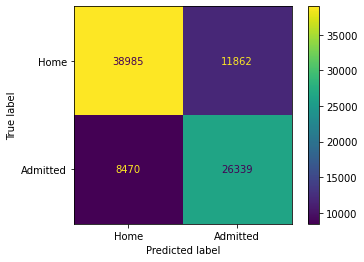

In [181]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_class), display_labels = ["Home","Admitted"])
disp.plot(values_format='')
plt.show()

In [182]:
pd.DataFrame(x_test_o).to_csv("x_test_o.csv",index=False)
pd.DataFrame(x_test).to_csv("x_test.csv",index=False)
pd.DataFrame(x_test_his).to_csv("x_test_his.csv",index=False)
pd.DataFrame(train_samples_o).to_csv("train_samples_o.csv",index=False)
pd.DataFrame(test_samples_his).to_csv("test_samples_his.csv",index=False)
pd.DataFrame(test_samples_chief).to_csv("test_samples_chief.csv",index=False)
pd.DataFrame(edstay_ad1).to_csv("edstay_ad1.csv",index=False)

In [183]:
x_test.shape

(85656, 5)

In [184]:
x_train.shape

(299799, 5)

In [185]:
x_val.shape

(42829, 5)